In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Load libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Load the dataset

In [37]:
#data = pd.read_csv("bitcoin_ticker.csv")
data=pd.read_csv("/content/drive/MyDrive/Bitcoin-price-Prediction-using-LSTM-master/bitcoin_ticker.csv")

In [38]:
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


Subset USD

In [39]:
data['rpt_key'].value_counts()

btc_usd       125438
btc_eur        62719
btc_jpy        62719
btc_krw        62719
etc_krw        62719
eth_btc        62719
eth_krw        62719
fx_btc_jpy     62719
ltc_usd        62719
Name: rpt_key, dtype: int64

In [40]:
df = data.loc[(data['rpt_key'] == 'btc_usd')]

Convert datetime_id to data type and filter dates greater than 2017-06-28 00:00:00

In [41]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [42]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

In [43]:
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
77762,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.0,2473.19,20719.583592
77763,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.0,2780.62,2265.557866
77764,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.0,2473.19,20732.082581
77765,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.0,2780.62,2262.618866
77766,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.0,2473.19,20665.357191


we require only the last value, so we subset that and convert it to numpy array

In [44]:
df = df[['last']]

In [45]:
dataset = df.values
dataset = dataset.astype('float32')

In [46]:
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]], dtype=float32)

Neural networks are sensitive to input data, especiallly when we are using activation functions like sigmoid or tanh activation functions are used. ISo we rescale our data to the range of 0-to-1, using MinMaxScaler

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [48]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

31942 15734


Now let us define the function called create_dataset, which take two inputs,

Dataset - numpy array that we want to convert into a dataset
look_back - number of previous time steps to use as input variables to predict the next time period

In [49]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [50]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [51]:
trainX

array([[0.1997695 , 0.49828053, 0.18666792, ..., 0.4975314 , 0.19973087,
        0.4860053 ],
       [0.49828053, 0.18666792, 0.4855442 , ..., 0.19973087, 0.4860053 ,
        0.18442059],
       [0.18666792, 0.4855442 , 0.18251848, ..., 0.4860053 , 0.18442059,
        0.48598576],
       ...,
       [0.53376245, 0.6943617 , 0.53105354, ..., 0.7082124 , 0.5205841 ,
        0.7081547 ],
       [0.6943617 , 0.53105354, 0.70823145, ..., 0.5205841 , 0.7081547 ,
        0.52665424],
       [0.53105354, 0.70823145, 0.5332055 , ..., 0.7081547 , 0.52665424,
        0.7081547 ]], dtype=float32)

In [52]:
trainY

array([0.18442059, 0.48598576, 0.19208527, ..., 0.52665424, 0.7081547 ,
       0.5206418 ], dtype=float32)

In [53]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Build our Model

In [54]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=256, verbose=2)

Epoch 1/500
125/125 - 2s - loss: 0.2353 - 2s/epoch - 17ms/step
Epoch 2/500
125/125 - 0s - loss: 0.0048 - 224ms/epoch - 2ms/step
Epoch 3/500
125/125 - 0s - loss: 0.0028 - 217ms/epoch - 2ms/step
Epoch 4/500
125/125 - 0s - loss: 0.0018 - 239ms/epoch - 2ms/step
Epoch 5/500
125/125 - 0s - loss: 9.7805e-04 - 234ms/epoch - 2ms/step
Epoch 6/500
125/125 - 0s - loss: 5.0638e-04 - 281ms/epoch - 2ms/step
Epoch 7/500
125/125 - 0s - loss: 2.9605e-04 - 297ms/epoch - 2ms/step
Epoch 8/500
125/125 - 0s - loss: 2.2021e-04 - 253ms/epoch - 2ms/step
Epoch 9/500
125/125 - 0s - loss: 1.9329e-04 - 232ms/epoch - 2ms/step
Epoch 10/500
125/125 - 0s - loss: 1.8126e-04 - 212ms/epoch - 2ms/step
Epoch 11/500
125/125 - 0s - loss: 1.7424e-04 - 219ms/epoch - 2ms/step
Epoch 12/500
125/125 - 0s - loss: 1.6959e-04 - 217ms/epoch - 2ms/step
Epoch 13/500
125/125 - 0s - loss: 1.6631e-04 - 232ms/epoch - 2ms/step
Epoch 14/500
125/125 - 0s - loss: 1.6371e-04 - 209ms/epoch - 2ms/step
Epoch 15/500
125/125 - 0s - loss: 1.6163e-04 - 

Build our Mode

In [55]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

We have to invert the predictions before calculating error to so that reports will be in same units as our original data

In [56]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])




In [57]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.56 RMSE
Test Score: 5.25 RMSE


In [58]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [59]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

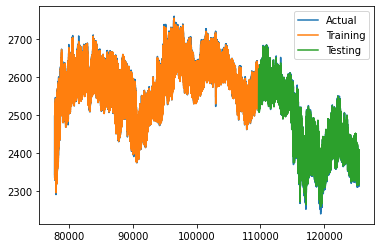

In [60]:
plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()